# T-Maze Interactive Simulation

This notebook executes the action-perception loop for a discrete SSM.

In [19]:
using Pkg
Pkg.activate("../..")
# Pkg.instantiate()

  Activating project at `c:\Simulations\EpistemicMessagePassing`


In [20]:
using LinearAlgebra
using ForneyLab
using Plots
using Random
using ForwardDiff: hessian
# using ProgressMeter

# T-maze layout
# [2| |3]
#   | |
#   |1|
#   |4|

include("factor_nodes/discrete_observation.jl")
include("update_rules/discrete_observation.jl")

Random.seed!(42)
;

# Generative Model

In [21]:
fg = FactorGraph()

u = Vector{Variable}(undef, 2)
x = Vector{Variable}(undef, 2)
y = Vector{Variable}(undef, 2)

@RV x_0 ~ Categorical(placeholder(:D_s, dims=(8,)))
@RV A ~ Dirichlet(placeholder(:A_s, dims=(16,8)))

x_k_min = x_0
for k=1:2
    @RV u[k]
    @RV x[k] ~ Transition(x_k_min, u[k])
    placeholder(u[k], :u, index=k, dims=(8,8))
    @RV y[k] ~ DiscreteObservation{Bethe}(x[k], A, # Choose Generalized or Bethe constraint
                   placeholder(:C, dims=(16,), var_id=:C_*k),
                   n_factors=8)
    
    x_k_min = x[k] # For next slice
end
;

# Algorithm

In [22]:
q = PosteriorFactorization(y, [x_0; x], A, ids=[:Y, :X, :A])
algo = messagePassingAlgorithm(q, free_energy=true)
code = algorithmSourceCode(algo, free_energy=true)
initX() = Array{Message}(undef, 9) # Predefine
eval(Meta.parse(code)) # Overwrites initX for Generalized constraint
;

In [23]:
# println(code)

## Action-Perception Loop

In [24]:
α = 0.9; c = 2.0 # Reward probability and utility
S = 100 # Number of simulations

include("helpers.jl")
include("environment.jl")
include("agent.jl")

(A, B, C, D) = constructABCD(α, c)
(A_0, D_0) = constructPriors() # Construct prior statistics for A and D

(reset, execute, observe) = initializeWorld(A, B, C, D) # Let there be a world
(infer, act) = initializeAgent(A_0, B, C, D_0) # Let there be a constrained agent

# Step through the experimental protocol
As = Vector{Matrix}(undef, S) # Posterior statistics for A
Gs = [Vector{Matrix}(undef, 3) for s=1:S] # Free energy values per time
as = [Vector{Int64}(undef, 2) for s=1:S] # Actions per time
os = [Vector{Vector}(undef, 2) for s=1:S] # Observations (1-of-K) per time
rs  = Vector{Int64}(undef, S) # Hidden reward positions
for s = 1:S
    rs[s] = reset() # Reset world
    for t = 1:2
        (Gs[s][t], _) = infer(t, as[s], os[s])
             as[s][t] = act(t, Gs[s][t])
                        execute(as[s][t])
             os[s][t] = observe()
    end
    (Gs[s][3], As[s]) = infer(3, as[s], os[s]) # Learn
end
;

# Results

In [25]:
sum([as[s].==rs[s] for s=1:S]) # Correct visits per timepoint

2-element Vector{Int64}:
  1
 96

In [26]:
include("visualizations.jl")

plotObservationStatistics(As[S], A_0)

4×8 SparseMatrixCSC{Float64, Int64} with 9 stored entries:
  ⋅   3.0    ⋅    ⋅    ⋅     ⋅   44.0    ⋅ 
  ⋅   4.0    ⋅    ⋅    ⋅     ⋅     ⋅   49.0
  ⋅    ⋅   36.0   ⋅    ⋅   50.0    ⋅     ⋅ 
  ⋅    ⋅    8.0  1.0   ⋅    5.0    ⋅     ⋅ 

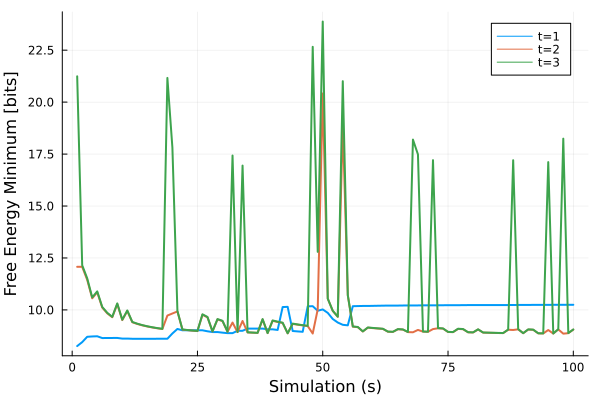

In [27]:
plotFreeEnergyMinimum(Gs)

In [28]:
hcat(as, rs)

100×2 Matrix{Any}:
 [4, 2]  3
 [4, 2]  2
 [4, 3]  3
 [4, 3]  3
 [4, 2]  2
 [4, 3]  3
 [4, 3]  3
 [4, 3]  3
 [4, 2]  2
 [4, 3]  3
 [4, 2]  2
 [4, 3]  3
 [4, 3]  3
 ⋮       
 [4, 2]  2
 [4, 3]  3
 [4, 2]  2
 [4, 2]  2
 [4, 3]  3
 [4, 3]  3
 [4, 2]  2
 [4, 3]  3
 [4, 2]  2
 [4, 3]  3
 [4, 3]  3
 [4, 2]  2

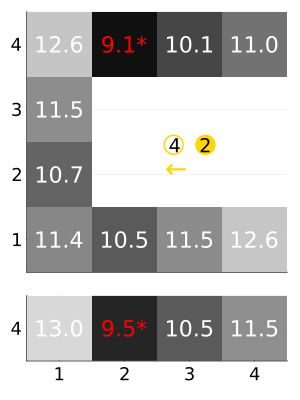

In [29]:
s = 40
plotFreeEnergies(Gs[s], as[s], os[s], rs[s])